# Coronavirus: The Simplest Model

Tom Nicholas

20/03/2020

---
## DISCLAIMER

I am not an epidemiologist! This model is for understanding and tutorial purposes only. It is not suitable for predictions or decision-making, and excludes many important considerations (some of which are listed below). It is intended primarily as an example of the power of basic programming in modelling a real-world problem, and an introduction to the mathematics of the spread of disease.

We will be able to use this basic model to reproduce the essence of some of the modelling results that appear in headlines and widely-shared articles at the moment, but this particular model is only meant to help you understand how those authors might have arrived at those conclusions. While the general trends indicated are indicative, the absolute numbers aren't necessarily.

It's also important to understand that most of the cases shown here assume that we do not manage to stamp out the virus in first month or so of infection, and so are worst-case scenarios. The model we're using is only representative of situations which might occur after that initial chance to stop a widespread epidemic is missed.

A similar but more detailed model created by an actual epidemiologist is [here](https://twitter.com/alison_l_hill/status/1239072817678823425).
For general information about the Coronavirus and advice for the public see the [World Health Organisation website](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/).

---

## Susceptible-Infected-Recovered-Deceased model

The simplest model appropriate for an influenza-type disease is called the SIRD model.
It breaks the population up into those who are Susceptible to becoming infected, those who are Infected, those who are Recovered, and those who are Deceased.

The SIRD model is suitable for the novel coronavirus if we assume that those who have recovered from the infection are henceforth immune to becoming infected again (otherwise they would return to the Suceptible population).

### Equations of the SIRD model

We follow the description of the SIRD model laid out in [Hethcote (1989)](http://www.mtholyoke.edu/~ahoyerle/math333/ThreeBasicModels.pdf).

The susceptible population $NS(t)$ decreases through contact with infected, at a rate given by $\lambda$:

\begin{equation}
\frac{d(NS)}{dt} = -\lambda S N I
\end{equation}

$\lambda$ is the "daily contact rate", which means that if everyone were suceptible and uninfected, one infected person would infect $\lambda$ people per day. So the average number of susceptibles infected by an infectious person per day is $\lambda S$.

The infected population $NI(t)$ increases through contact with infected (at a rate set by $\lambda$), decreases through recovery, at a rate $\gamma$, and also decreases through death, at a rate $\mu$.

\begin{equation}
\frac{d(NI)}{dt} = \lambda S N I - \gamma N I - \mu N I
\end{equation}

What does $\gamma$ mean? Individuals recover and are removed from the infective class at a rate proportional to the number of infectives with proportionality constant $\gamma$, called the daily recovery removal rate.

The latent period is zero (it is defined as the period between the time of exposure and the time when infectiousness begins).
Thus the proportion of individuals exposed (and immediately infective) at time $t_0$ who are still infective at time $t_0 + t$ is $\exp(-\gamma t)$, and the average period of infectivity is $P=1/\gamma$.

The recovered population $NR(t)$ increases when members of the infected population recover. We assume (for now) that all recovered people are henceforth immune to being infected a second time.

\begin{equation}
\frac{d(NR)}{dt} = \gamma I N
\end{equation}

The deceased population $ND(t)$ increases through death at a rate $\mu$
\begin{equation}
\frac{d(ND)}{dt} = \mu I N
\end{equation}

Members of the infected population leave $I(t)$ either by recovering (at a rate $\gamma$), or dying (at a rate $\mu$).
Therefore the chance of an infected individual dying (the average mortality) is $M=\mu/\gamma$.

The "basic reproductive number" (also known as "contact number") $R_0$ is defined as $R_0=\lambda / (\gamma + \mu)$. This comes from the fact that accounting for the deaths of infected gives a death-adjusted average period of infectivity of $1/(\gamma + \mu)$, and multiplying that time period by the daily contact rate $\lambda$.

The fact that the membership of all groups together must add up to the total population is expressed as
\begin{equation}
NS + NI + NR + ND = N
\end{equation}
We've also assumed that the total population is constant (including deceased), and that the epidemic occurs in a timeframe much shorter than that over which natural births and deaths significantly affect any of the populations.

Now we can simplify our equations by dividing through by $N$

\begin{align}
\frac{dS}{dt} & = -\lambda S I \\
\frac{dI}{dt} & = \lambda S I - \gamma I - \mu I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dD}{dt} & = \mu I 
\end{align}

and we also have the boundary condition
\begin{equation}
S + I + R + D = 1
\end{equation}

Diagrammatically, these equations reqpresent a set of states ($S$, $I$, $R$ & $D$), connected by transfer rates ($\lambda SI$, $\gamma I$, $\mu I$):

![levels](SIRD_states.png)

### Exponential growth

Before we even write any code we can already identify the main feature of these equations: the number of Infected will grow exponentially.

Why? Exponential growth is when the rate of change of a quantity is proportional to the size of that quantity. If we assume that the recovery rate $\gamma$ and death rate $\mu$ are small compared to the infection rate $\lambda S$, (and that the susceptible population is large enough that it is roughly constant to begin with) then at the start we have
\begin{align}
\frac{dI(t)}{dt} & = (\lambda S - \gamma - \mu) I(t) \\
                 & = \lambda ( S - \frac{(\gamma + \mu)}{\lambda}) I(t) \\
                 & = \lambda ( S - \frac{1}{R_0}) I(t)
\end{align}
the solution of which is
\begin{equation}
I(t) \propto e^{~ \lambda ( S - \frac{1}{R_0}) I}
\end{equation}
so as $\lambda>0$ always, and at the beginning $S \sim 1$, then the infection will grow exponentially if $R_0 > 1$.

## Solving the equations for the Coronavirus

Okay let's try and model the coronavirus by solving these equations.

Our equations are a system of linear ordinary differential equations, and we will start from a set of known initial values, so we're going to need `scipy`'s [`integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. 

In [1]:
from scipy.integrate import solve_ivp
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np

### Population parameters

We need to pick initial conditions, which are the number of people in each population (susceptible, infected etc.) to start from.
Here we will model the UK, but we can get the up-to-date numbers for any country from [this website](https://www.worldometers.info/coronavirus/countries-where-coronavirus-has-spread/), which is updated daily.

In [2]:
# Reported UK coronavirus numbers on 18th March 2020
# cases means total reported cases including resolved
uk_initial_conditions = {'population': 66440000,
                         'cases': 2626,
                         'deaths': 104,
                         'recovered': 65}

### Virus parameters

We also need parameters which describe the properties of the coronavirus.

The basic reproductive rate of the virus $R_0$ (in the absence of any social distancing measures) has been [estimated to be between 2.0-2.6](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf?fbclid=IwAR1j0zcv_htn0A6OHNGhDkV5Facsz_jLVJxYtel7MEl1b7VvBsPgnkcXMAM), and we'll use 2.4.

For the mortality we'll use an average of 1%, as a rough representation of the value [of 1.4% case fatality rate given here](https://www.researchsquare.com/article/rs-17453/v1).

We'll use 14 days for the average infectious period.

Let's write out the equations for the derivatives we need to calculate, then create a class which will set up the problem, solve it, and plot the solution.

In [3]:
class SIRD:
    def __init__(self, R0, M, P):
        # Model parameters
        self.R0 = R0
        self.M = M
        self.P = P

    def dSdt(self, S, I, lamb):
        return -lamb*S*I

    def dIdt(self, S, I, lamb, gamma, mu):
        return lamb*S*I - gamma*I - mu*I

    def dRdt(self, I, gamma):
        return gamma*I

    def dDdt(self, I, mu):
        return mu*I
        
    def eqns(self, t, y, lamb, gamma, mu):
        S, I, R, D = y
        return [self.dSdt(S, I, lamb),
                self.dIdt(S, I, lamb, gamma, mu), 
                self.dRdt(I, gamma),
                self.dDdt(I, mu)]
    
    def setup(self, population, cases, recovered, deaths):
        # Compute initial values
        self.population = population
        initial_S = (population - cases) / population
        initial_R = recovered / population 
        initial_D = deaths / population
        initial_I = 1 - initial_S - initial_R - initial_D
        self.y0 = [initial_S, initial_I, initial_R, initial_D]

        # Compute coefficients
        self.gamma = 1 / self.P
        self.mu = self.gamma * self.M
        self.lamb = self.R0 * (self.gamma + self.mu)

    def solve(self, initial_conditions, tf=300):
        
        self.setup(initial_conditions['population'],
                   initial_conditions['cases'],
                   initial_conditions['recovered'],
                   initial_conditions['deaths'])
        
        t_span = (0, tf)  # tf is number of days to run simulation for, defaulting to 300
    
        self.soln = solve_ivp(self.eqns, t_span, self.y0,
                              args=(self.lamb, self.gamma, self.mu),
                              t_eval=np.linspace(0, tf, tf*2))
        return self
    
    def plot(self, ax=None, susceptible=True):
        S, I, R, D = self.soln.y
        t = self.soln.t
        N = self.population

        print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
        print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
        print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
        print(f"At the virus' maximum {I.max()*100:.1f}% people were simultaneously infected, or {I.max()*N:.0f} people.")
        print(f"After {t[-1]:.0f} days the virus was present in less than {I[-1]*N:.0f} individuals.")

        if ax is None:
            fig, ax = plt.subplots()
        
        ax.set_title("Covid-19 spread")
        ax.set_xlabel("Time [days]")
        ax.set_ylabel("Number")
        if susceptible:
            ax.plot(t, S*N, label="Susceptible", linewidth=2, color='blue')
        ax.plot(t, I*N, label="Infected", linewidth=2, color='orange')
        ax.plot(t, R*N, label="Recovered", linewidth=2, color='green')
        ax.plot(t, D*N, label="Deceased", linewidth=2, color='black')
        ax.legend()

        return ax

We initialise this with our choice of model coefficients

In [4]:
R0 = 2.4   # Basic Reproductive Rate [people]
M = 0.01   # Mortality ratio [fraction]
P = 14     # Average infectious period [days] (should really be split up by case severity)
sird = SIRD(R0, M, P)

and now solve the model forward in time

For a population of 66440000 people, after 300 days there were:
0.9% total deaths, or 575261 people.
86.6% total recovered, or 57515786 people.
At the virus' maximum 21.8% people were simultaneously infected, or 14503231 people.
After 300 days the virus was present in less than 1814 individuals.


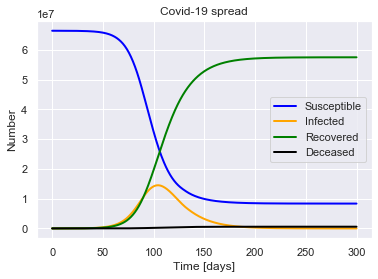

In [5]:
sird.solve(uk_initial_conditions)
sird.plot()

## (Interactivity)

We can use the ipywidgets library to make the inputs interactive (will only display if you're running the code in this notebook yourself).

In [6]:
from ipywidgets import interact, fixed
from ipywidgets import IntSlider, IntRangeSlider, FloatSlider, Dropdown

In [7]:
P_slider = IntSlider(min=1, max=30, step=1, value=14)
R0_slider = FloatSlider(min=0.1, max=15, step=0.1, value=2.6)
M_slider = FloatSlider(min=0.001, max=0.05, step=0.001, value=0.035)

In [8]:
@interact(R0=R0_slider, M=M_slider, P=P_slider,
          initial_conditions=fixed(uk_initial_conditions),
          continuous_update=False)
def run_sird(R0, M, P, initial_conditions):
    SIRD(R0, M, P).solve(initial_conditions).plot()

interactive(children=(FloatSlider(value=2.6, description='R0', max=15.0, min=0.1), FloatSlider(value=0.035, de…

## Social distancing

How can social distancing help? 

Social distancing effectively reduces $R_0$. If $R_0=0$ (everyone lives alone in a box) then there would be no new infections, and the disease would die out once all the infected had either recovered or died.

If $R_0 < 1$ then new people will still be infected, but not fast enough to sustain the virus, and the contagion will decay away.

But if $R_0>1$, even if only a bit greater, than the virus will still grow exponentially.
It will grow more slowly, but will still pick up pace, becoming faster and faster.

So why do social distancing? If we can decrease $R_0$, in other words we can `#flattenthecurve`.

## Lockdown policies

But just changing $R_0$ overall isn't realistic, it assumes that as soon as the virus was discovered, everyone who is near it practices social distancing immediately and indefinitely.
What is more realistic is that once it's realised that the disease could cause an epidemic, governments encourage (or enforce) varying degrees of social distancing through policies like quarantining, lockdowns, banning large events, and working from home.

How can we parameterise a change in the effectiveness of social distancing through policies like these?
Let's try adjusting $R_0$ using a "quarantine parameter" $Q$.
When $Q=0$ then the disease spreads freely, but when $Q=1$ we are on total lockdown and the disease can't spread at all.

We can represent this by changing our equations for the fraction of susceptible and infected people to

\begin{align}
\frac{dS}{dt} & = -\lambda(1 - Q) S I \\
\frac{dI}{dt} & = \lambda(1 - Q) S I - \gamma I - \mu I
\end{align}

If we make $Q$ a function of time $Q=Q(t)$, then we can simulate the effect of varying the level of social distancing in response to the virus.

We can model a sudden permanent lockdown by setting $Q=Q_0H(t-t_Q)$, where $H$ is the heaviside step function
\begin{equation} 
H(t) = 
  \begin{cases} 
    0 & t\lt t_Q \\
    1 & t\geq t_Q 
  \end{cases}
\end{equation}
This just means there are zero social distancing measures in place before day $t_Q$, and then immediate distancing measures of effectiveness $Q$ are enforced permanently from day $t_Q$.

To model this, we need $\frac{dS}{dt} = \frac{d}{dt}S(Q(t-t_Q))$

In [9]:
class SIRDQ(SIRD):
    def __init__(self, R0, M, P, Q0, tQ):
        super().__init__(R0, M, P)
        self.Q0 = Q0
        self.tQ = tQ

    def dSdt(self, S, I, lamb, Q):
        return -lamb*(1-Q)*S*I

    def dIdt(self, S, I, lamb, gamma, mu, Q):
        return lamb*(1-Q)*S*I - gamma*I - mu*I
    
    def Q(self, t):
        if t > self.tQ:
            return self.Q0
        else:
            return 0

    def eqns(self, t, y, lamb, gamma, mu):
        S, I, R, D = y

        return [self.dSdt(S, I, lamb, self.Q(t)),
                self.dIdt(S, I, lamb, gamma, mu, self.Q(t)), 
                self.dRdt(I, gamma),
                self.dDdt(I, mu)]
    
    def solve(self, initial_conditions, tf=300):
        return super().solve(initial_conditions, tf)
    
    def plot(self, ax=None, susceptible=True):
        ax = super().plot(ax, susceptible)
        return plot_social_distancing_event(ax, self.Q0, self.tQ, 'Begin')

In [10]:
def plot_social_distancing_event(ax, Q0, t_Q, limit):
    print(f"{limit} social distancing of effectiveness {Q0} on day {t_Q}.")
    
    # Mark intervention point
    ax.axvline(x=t_Q, linewidth=2, color='black', linestyle='--')
    ax.text(x=t_Q+5, y=0.8*ax.get_ylim()[1], s=f"{limit} \nSocial \nDistancing \n")
    return ax

For a population of 66440000 people, after 300 days there were:
0.3% total deaths, or 192619 people.
29.0% total recovered, or 19251533 people.
At the virus' maximum 5.8% people were simultaneously infected, or 3870304 people.
After 300 days the virus was present in less than 38013 individuals.
Begin social distancing of effectiveness 0.6 on day 75.


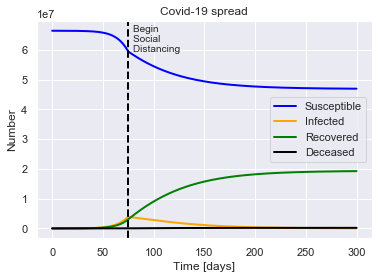

In [11]:
SIRDQ(R0=2.4, M=0.01, P=14, Q0=0.6, tQ=75).solve(uk_initial_conditions).plot()

These policies might be implemented only once the virus has been spreading for a while.

In [12]:
Q0_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5)
tQ_slider = IntSlider(min=0, max=300, value=75)

In [13]:
@interact(R0=R0_slider, M=M_slider, P=P_slider, Q0=Q0_slider, tQ=tQ_slider, 
          initial_conditions=fixed(uk_initial_conditions),
          continuous_update=False)
def run_sirdq(R0, M, P, Q0, tQ, initial_conditions):
    SIRDQ(R0, M, P, Q0, tQ).solve(initial_conditions).plot()

interactive(children=(FloatSlider(value=2.6, description='R0', max=15.0, min=0.1), FloatSlider(value=0.035, de…

Or perhaps these policies will only be ramped up when there are lots of people infected. 

## Second wave?

The deadliest part of the 1918 Spanish Flu epidemic was the second wave that remerged in the winter.

Although it's yet not clear if Covid-19 is significantly affected by temperature, there are also fears that slacking off on isolation measures will trigger a second wave.

Can we model this possibility?

Let's alter our $Q(t)$ to also stop isolation measures at a certain point in time. Let's call this time $t_{UQ}$ (for "Un-Quarantine"). Then $Q$ becomes

\begin{equation} 
Q(t) = 
  \begin{cases} 
    0 & t\lt t_Q \\
    Q_0 & t_Q \leq t \lt t_{UQ} \\
    0 & t\geq t_{UQ}
  \end{cases}
\end{equation}

In [14]:
class SIRDUQ(SIRDQ):
    def __init__(self, R0, M, P, Q0, tQ, tUQ):
        super().__init__(R0, M, P, Q0, tQ)
        self.tUQ = tUQ

    def Q(self, t):
        if self.tQ < t <= self.tUQ:
            return self.Q0
        else:
            return 0

    def plot(self, ax=None):
        ax = super().plot(ax)
        return plot_social_distancing_event(ax, self.Q0, self.tUQ, 'End')

For a population of 66440000 people, after 300 days there were:
0.8% total deaths, or 532994 people.
80.2% total recovered, or 53289019 people.
At the virus' maximum 12.1% people were simultaneously infected, or 8052134 people.
After 300 days the virus was present in less than 629758 individuals.
Begin social distancing of effectiveness 0.7 on day 75.
End social distancing of effectiveness 0.7 on day 150.


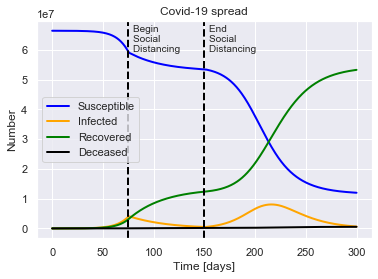

In [15]:
SIRDUQ(R0=2.4, M=0.01, P=14, Q0=0.7, tQ=75, tUQ=150).solve(uk_initial_conditions).plot()

## Healthcare capacity

So far our model assumes that everyone who catches the virus continues to act normally, but has a $L=\mu/\gamma$ chance of dying.

This is unrealistic for multiple important reasons, but one of those is that an individual's chance of survival depends greatly on whether there are sufficient medical resources available to tend to them. 
Any hospital, and the healthcare system as a whole, has a certain capacity for patients.
If the demand for care greatly exceeds this capacity then patients will unfortunately recieve less of the care that they need.
In reality, this comes about because a patient's chance of survival will depend on whether or not beds are available, how many patients doctors and nurses have to try and care for at once, and whether or not more specialist equipment such as intubators and Intensive Care Units are available.

Trying to model the availability of doctors, nurses, beds, ICUs and so on is complicated, so here we will try and make the simplest model which still captures the essential idea of healthcare system capacity.

We're going to use a simple, clear and constant metric to describe healthcare system capacity - the number of hospital beds available per person in the total population, $B$.

We are then going to relate the number of infected people to the death rate via $B$.
We'll do this by assuming that if the number of severely ill patients exceeds the number of beds available, the mortality rate for those patients will increase from $\mu_B$ to a greater value $\mu_{NB}$. We'll also assume that a fraction $f_S$ of infected cases are severe enough to require a bed in a hospital.

So we set $\mu=\mu(I, B, \beta, f_S)$, specifically
\begin{equation} 
\mu(I) = 
  \begin{cases} 
    \mu_B & f_S I \leq B \\
    (\mu_{NB}-\mu_B)\frac{(f_S I-B)}{f_S I} + \mu_B & f_S I \gt B
  \end{cases}
\end{equation}

The reason for the complex expression when $I>B$ is because we're assuming that only those patients for whom there is no bed suffer the higher mortality rate. 
(If we didn't do this and simply used $\mu_{NB}$ then exceeding the healthcare capacity by one person could dramatically increase the mortality for all patients, which is clearly not realistic, and could possibly also lead to weird oscillations in the model around $I=B$.)

We'll parameterise this in the model by setting $\mu_{NB}=\beta \mu_B$, where $\beta > 1$. So if the mortality rate for a patient without a hospital bed were twice that for a patient with one, $\beta=2$.

In [16]:
class SIRDQB(SIRDQ):
    def __init__(self, R0, M, P, Q0, tQ, B, fS, beta):
        super().__init__(R0, M, P, Q0, tQ)
        self.B = B
        self.fS = fS
        self.beta = beta
        
    # Locally redefine mu(I)
    def mu_I(self, I):
        if I > self.B:
            return ((self.beta - 1)*(I - self.B)/I + 1) * self.mu
        else:
            return self.mu
    
    def eqns(self, t, y, lamb, gamma, mu):
        S, I, R, D = y
    
        return [self.dSdt(S, I, lamb, self.Q(t)),
                self.dIdt(S, I, lamb, gamma, self.mu_I(I*self.fS), self.Q(t)), 
                self.dRdt(I, gamma),
                self.dDdt(I, self.mu_I(I*self.fS))]

    def plot(self, ax=None):
        ax = super().plot(ax)
        return plot_bed_capacity(ax, self.B, self.population)
        
def plot_bed_capacity(ax, B, N):
    print(f"Hospital bed capacity of {B*1000} beds per 1000 people.")

    ax.axhline(y=N*B, linewidth=2, color='red', linestyle='--')
    ax.text(x=5, y=N*B, s=f"Hospital \nBed \nCapacity \n")
    return ax

In [17]:
B = 0.0024  # Hospital beds per person in the UK
fS = 0.1   # Fraction of Covid-19 cases which are severe enough to require a bed
beta = 2    # How many times more likely a severely-ill patient is to die without a bed as opposed to with one

For a population of 66440000 people, after 300 days there were:
0.0% total deaths, or 13693 people.
2.0% total recovered, or 1359009 people.
At the virus' maximum 0.4% people were simultaneously infected, or 258213 people.
After 300 days the virus was present in less than 258213 individuals.
Begin social distancing of effectiveness 0.5 on day 5.
Hospital bed capacity of 2.4 beds per 1000 people.


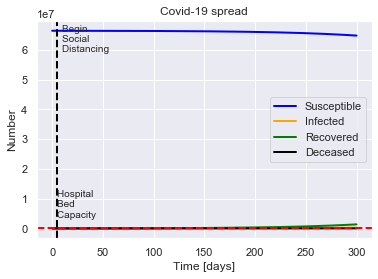

In [18]:
SIRDQB(R0=2.4, M=0.01, P=14, Q0=0.5, tQ=5, B=B, fS=fS, beta=beta).solve(uk_initial_conditions).plot()

## Flattening the curve

You've probably heard about how we should all be practicing social distancing to help "flatten the curve".
We're now in a position to model why flattening the curve helps.

In [19]:
def plot_curve_flattening(initial_conditions, 
                          R0, M, P, tQ, Q_values):
    
    tf = 500  # plot over longer period of time
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title("Flattening the curve")
    ax1.set_xlabel("Time [days]")
    ax1.set_ylabel("Number of severe cases")
    
    N = initial_conditions['population']
    
    mortality = []
    for Q0 in Q_values:
        sirdqb = SIRDQB(R0, M, P, Q0, tQ, B, fS, beta)
        sirdqb = sirdqb.solve(initial_conditions, tf)
        
        soln = sirdqb.soln
        S, I, R, D = soln.y
        t = soln.t
    
        # Flattened curves
        ax1.plot(t, fS*I*N, linewidth=2)
        ax1.text(x=t[np.argmax(I)]+7, y=N*fS*I.max(), s=f'Q={Q0}')
        
        mortality.append(D[-1]/R[-1])
        
    ax1 = plot_bed_capacity(ax1, B, N)
    
    # Mortality rates
    ax2.set_title("Effect of flattening the curve on mortality rate")
    ax2.set_xlabel("Success of social distancing [Q]")
    ax2.set_ylabel("Overall mortality rate [deaths/cases]")
    ax2.plot(Q_values, mortality, linewidth=2, color='black')
    
    plt.show()

Hospital bed capacity of 2.4 beds per 1000 people.


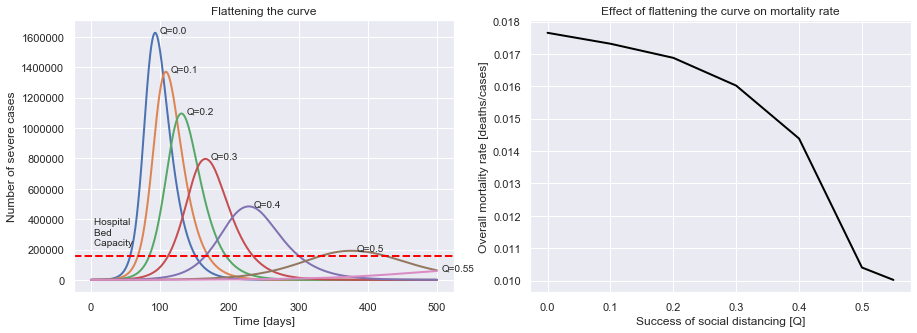

In [20]:
plot_curve_flattening(uk_initial_conditions, R0=2.6, M=0.01, P=14, tQ=0, 
                      Q_values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55])

We can now see that the better our social distancing is, the fewer cases there are at once, minimising overload of the healthcare system, and so reducing the chance that those who contract Covid-19 die from it. Social distancing doesn't just decrease the number of people who will get infected, it also gives those who do get infected a better chance!

## Protecting the vulnerable

One of the biggest omissions of the this model so far is that there is no distinction made between vulnerable and not-so-vulnerable people.
Instead the population is modelled as homogenous and evenly-mixed, with an overall average mortality.

However, we know that Covid-19 is [far more dangerous](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) to the elderly, to those with compromised immune systems, or with certain other pre-existing health conditions. We also know that the vast majority of cases in children and young people are mild.

This property of the disease could help us to save lives, if we put measures in place designed specifically to protect the vulnerable from infection (e.g. quarantining care homes).

How can we model this in the simplest possible way? We need to divide our susceptible $S(t)$ population into at least two groups, the vulnerable $S_{V}(t)$ and the non-vulnerable $S_{NV}(t)$. We also need to divide up our infected population $I(t)$ into $I_V(t)$ and $I_{NV}(t)$, because a demographically-averaged mortality rate is no longer applicable if most of the infected are not the vulnerable ones. Recovered and deceased populations do not need to be subdivided.

To be able to control this subdivision of infection, the model needs a way to represent decreasing the transmission rate to the vulnerable specifically.
Therefore, we have to split our averaged $\lambda$ up according to whether it represents the rate of transmission from vulnerable to non-vulnerable, vulnerable to vulnerable etc.
We'll also need to split up the death rate $\mu$, and the recovery rate $\gamma$.

\begin{align}
\frac{dS_V}{dt} & = -(\lambda_{V-V}I_{V} + \lambda_{NV-V}I_{NV}) S_V  \\
\frac{dS_{NV}}{dt} & = -(\lambda_{V-NV}I_{V} + \lambda_{NV-NV}I_{NV}) S_{NV} \\
\frac{dI_V}{dt} & = (\lambda_{V-V} I_V + \lambda_{NV-V} I_{NV}) S_V - \gamma_V I_V - \mu_V I_V \\
\frac{dI_{NV}}{dt} & = (\lambda_{V-NV} I_V + \lambda_{NV-NV} I_{NV}) S_{NV} - \gamma_{NV} I_{NV} - \mu_{NV} I_{NV} \\
\frac{dR}{dt} & = \gamma_V I_V + \gamma_{NV} I_{NV} \\
\frac{dD}{dt} & = \mu_V I_V + \mu_{NV} I_{NV}
\end{align}

and the boundary condition becomes
\begin{equation}
S_V + S_{NV} + I_V + I_{NV} + R + D = 1
\end{equation}

As an aside, if we wanted to subdivide the populations further (for example by age bracket), we would instead write $S(t)$ as a vector of subsceptible subpopulations $\mathbf{S}(t)=(S_0(t), S_1(t), ...)$, and promote $\lambda$ to be matrix.

\begin{align}
\frac{dS_i}{dt} & = \sum_{ij} -\lambda_{ij} I_i S_j  \\
\frac{dI_i}{dt} & = \sum_{ij} \lambda_{ij} S_j I_i - \sum_i (\gamma_i I_i + \mu_i I_i) \\
\frac{dR}{dt} & = \sum_i \gamma_i I_i \\
\frac{dD}{dt} & = \sum_i \mu_i I_i
\end{align}

and the boundary condition would become
\begin{equation}
\sum_i \left(S_i + I_i \right) + R + D = 1
\end{equation}

We have a lot of extra coefficients here. Still aiming for the simplest way to represent this additional complication, we ideally only want one extra parameter to quantify the extent to which we successfuly manage to isolate (and hence hopefully protect) the vulnerable.

We going to create a separation parameter $\alpha$, which must correspond to the same model as before when $\alpha=0$, and total separation when $\alpha=1$. We'll relate it to our original daily contact rate $\lambda_0$ via

\begin{align}
\lambda_{NV-NV} & = \lambda_{V-V} = \lambda_0 \\
\lambda_{NV-V} & = \lambda_{V-NV} = (1-\alpha) \lambda_0
\end{align}

This basically assumes that we have two populations, which each have the same internal transmission rate as before, but have a reduced transmission rate between populations.

(Eagle-eyed readers will notice this change has altered the determinant of the tranmission matrix $\text{det}(\lambda_{ij})$, which means the total averaged rate of transmission in the whole population is now a function of $\alpha$. That means our decoupling method isn't pure, it has a side-effect of reducing overall transmission. I'm going to ignore that, because correcting for it would mean artificially increasing the transmission within each separate population when $\alpha$ is increased, which seems sillier.)

In [21]:
def SIRDV_eqns(t, y, lamb_0, gamma, mu_V, mu_NV, alpha):
    S_V, S_NV, I_V, I_NV, R, D = y
    
    def dSVdt(S_V, I_V, I_NV, lamb_VV, lamb_NVV):
        return -(lamb_VV * I_V + lamb_NVV * I_NV) * S_V

    def dSNVdt(S_NV, I_V, I_NV, lamb_NVNV, lamb_VNV):
        return -(lamb_NVNV * I_NV + lamb_VNV * I_V) * S_NV

    def dIVdt(S_V, I_V, I_NV, lamb_VV, lamb_NVV, gamma, mu_V):
        return (lamb_VV * I_V + lamb_NVV * I_NV) * S_V - gamma*I_V - mu_V*I_V

    def dINVdt(S_NV, I_V, I_NV, lamb_NVNV, lamb_VNV, gamma, mu_NV):
        return (lamb_VNV * I_V + lamb_NVNV * I_NV) * S_NV - gamma*I_NV - mu_NV*I_NV

    def dRdt(I_V, I_NV, gamma):
        return gamma*(I_V + I_NV)

    def dDdt(I_V, I_NV, mu_V, mu_NV):
        return mu_V*I_V + mu_NV*I_NV

    lamb_VV = lamb_0
    lamb_NVNV = lamb_0
    lamb_VNV = lamb_0 * (1 - alpha)
    lamb_NVV = lamb_0 * (1 - alpha)
    
    return [dSVdt(S_V, I_V, I_NV, lamb_VV, lamb_NVV),
            dSNVdt(S_NV, I_V, I_NV, lamb_NVNV, lamb_VNV),
            dIVdt(S_V, I_V, I_NV, lamb_VV, lamb_NVV, gamma, mu_V), 
            dINVdt(S_NV, I_V, I_NV, lamb_NVNV, lamb_VNV, gamma, mu_NV), 
            dRdt(I_V, I_NV, gamma),
            dDdt(I_V, I_NV, mu_V, mu_NV)]

We will roughly define the "vulnerable" population to be those aged $>70$, which for demographics similar to the UK means the vulnerable fraction $f_V=0.12$ (as [11.7% of the UK is aged over 70](https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/demographics/age-groups/latest)).

The chance of an infected individual dying from the disease is $L_i = \mu_i / \gamma_i$, where $i$ could be for $V$ or $NV$.
For simplicity's sake we're going to assume that the rate of recovery is the same for both populations (so $\gamma_V = \gamma_{NV} = \gamma_0$). However we will assume that the lethality ratio is very different: $L_{V} = 0.07$ while $L_{NV} = 0.002$. These numbers are roughly chosen from table 1 of the [Imperial College Report](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf?fbclid=IwAR1j0zcv_htn0A6OHNGhDkV5Facsz_jLVJxYtel7MEl1b7VvBsPgnkcXMAM), in such a way that the population-averaged mortality is still the same as in the previous model

\begin{equation}
L_\text{avg} = L_V f_V + (1 - f_V) L_{NV}
\end{equation}

To start our new model, we also need the initial conditions: we'll assume that the fraction of infected cases so far is divided in the same way as the overall population. 

In [29]:
M_NV = 0.002  # Mortality ratio of the vulnerable population
M_V = 0.07    # Mortality ratio of the non-vulnerable population

f_V = 0.12    # Fraction of the population considered vulnerable

alpha = 0.5   # Effectiveness of isolating the vulnerable population

N = uk_initial_conditions['population']

In [30]:
def setup_SIRDV(N, cases, recovered, deaths, f_V,
                P, M_V, M_NV, R_0, alpha):

    # Compute initial values
    R0 = recovered/N
    D0 = deaths/N
    S0 = (N - cases)/N
    I0 = 1 - S0 - R0 - D0
    
    S_V0 = S0 * f_V
    S_NV0 = S0 * (1-f_V)
    I_V0 = I0 * f_V
    I_NV0 = I0 * (1-f_V)
    
    initial = [S_V0, S_NV0, I_V0, I_NV0, R0, D0]

    # Compute coefficients
    gamma = 1 / P
    mu_V = gamma * M_V
    mu_NV = gamma * M_NV
    mu_avg = mu_V * f_V + mu_NV * (1-f_V) 
    lamb_0 = R_0 * (gamma + mu_avg)

    return initial, lamb_0, gamma, mu_V, mu_NV

In [31]:
def solve_SIRDV(eqns, N, cases, recovered, deaths,
                P, M_V, M_NV, R_0, alpha, tf=300):
    
    initial, lamb_0, gamma, mu_V, mu_NV = setup_SIRDV(N, cases, recovered, deaths, f_V,
                                                      P, M_V, M_NV, R_0, alpha)
    
    t_span = (0, tf)  # tf is number of days to run simulation for, defaulting to 300
    
    soln = solve_ivp(eqns, t_span, initial, args=(lamb_0, gamma, mu_V, mu_NV, alpha),
                     t_eval=np.linspace(0, tf, tf*2))
    return soln

In [32]:
def plot_SIRDV_solution(soln, N):
    
    S_V, S_NV, I_V, I_NV, R, D = soln.y
    t = soln.t

    print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
    print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
    print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
    print(f"At the virus' maximum {(I_V + I_NV).max()*100:.1f}% people were simultaneously infected, or {(I_V + I_NV).max()*N:.0f} people.")
    print(f"After {t[-1]:.0f} days the virus was present in less than {(I_V + I_NV)[-1]*N:.0f} individuals.")
    
    fig, ax = plt.subplots()
    ax.set_title("Covid-19 spread")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Number")
    ax.plot(t, S_V*N, label="Susceptible and Vulnerable", linewidth=2, color='blue')
    ax.plot(t, S_NV*N, label="Susceptible and Non-Vulnerable", linewidth=2, color='blue', linestyle='--')
    ax.plot(t, I_V*N, label="Infected and Vulnerable", linewidth=2, color='orange')
    ax.plot(t, I_NV*N, label="Infected and Non-Vulnerable", linewidth=2, color='orange', linestyle='--')
    ax.plot(t, R*N, label="Recovered", linewidth=2, color='green')
    ax.plot(t, D*N, label="Deceased", linewidth=2, color='black')
    ax.legend()
    
    start_total_people = N*(S_V[0] + S_NV[0] + I_V[0] + I_NV[0] + R[0] + D[0])
    end_total_people = N*(S_V[-1] + S_NV[-1] + I_V[-1] + I_NV[-1] + R[-1] + D[-1])  
    
    return ax

In [33]:
def plot_virus_spread(N, initial_cases, initial_recovered, initial_deaths,
                      P, M_V, M_NV, R_0, alpha):
    
    
    soln = solve_SIRDV(SIRDV_eqns, N, initial_cases, initial_recovered, initial_deaths,
                       P, M_V, M_NV, R_0, alpha)
    ax = plot_SIRDV_solution(soln, N)
    plt.show()

In [34]:
plot_virus_spread(N, cases, recovered, deaths,
                  P, M_V, M_NV, R_0, alpha=0.8)

NameError: name 'cases' is not defined

In [ ]:
def plot_protecting_the_vulnerable(N, initial_cases, initial_recovered, initial_deaths, 
                                   P, M_V, M_NV, R_0, alpha_values):
    
    tf = 500  # plot over longer period of time
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title("Reducing transmission to the vulnerable")
    ax1.set_xlabel("Time [days]")
    ax1.set_ylabel("Number of vulnerable cases")
    
    ax2.set_title("Effect of reducing transmission to the vulnerable on mortality rate")
    ax2.set_xlabel("Success of reducing transmission to the vulnerable [alpha]")
    ax2.set_ylabel("Overall mortality rate [deaths/cases]")
    
    mortality = []
    for alpha in alpha_values:
        soln = solve_SIRDV(SIRDV_eqns, N, 
                           initial_cases, initial_recovered, initial_deaths,
                           P, M_V, M_NV, R_0, alpha, tf=300)
        S_V, S_NV, I_V, I_NV, R, D = soln.y
        t = soln.t
    
        # Flattened curves
        ax1.plot(t, I_V*N, linewidth=2)
        ax1.text(x=t[np.argmax(I_V)]+7, y=N*I_V.max(), s=f'alpha={alpha}')
        
        mortality.append(D[-1]/R[-1])
    
    # Mortality rates
    ax2.plot(alpha_values, mortality, linewidth=2, color='black')
    
    plt.show()

In [ ]:
plot_protecting_the_vulnerable(N, cases, recovered, deaths, P=14, M_V=0.07, M_NV=0.002, R_0=2.4,
                               alpha_values=[0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])

## Immediate suppression

Even with these mitigation policies, the results are horrifying. What's the best-case outcome?

We could instead go all-out to try and [stop the virus](https://medium.com/@tomaspueyo/coronavirus-the-hammer-and-the-dance-be9337092b56) in its tracks immediately.

If we could get the reproductive rate of the virus $r$<0, the infection would exponentially decay instead of growing.

Therefore we need
\begin{equation}
( S - \frac{1}{R_0(1-Q)})  < 0
\end{equation}

or 
\begin{equation}
R_0 (1-Q) < 1
\end{equation}

For our typical coronavirus parameters, $S\sim 1$, and $R_0 \approx 2.4$, this implies we need $Q>0.59$.

[This work](https://045.medsci.ox.ac.uk/) suggests that with efficient contact tracing and isolation, we could get $r$ down to $\approx$ $0.1$.
As

\begin{equation}
r = S - \frac{1}{R_0(1-Q)},
\end{equation}

then this can be represented in our model as

\begin{equation}
Q = 1 - \frac{1}{(S + r)R_0} = 0.62
\end{equation}

For a population of 66440000 people, after 100 days there were:
0.0% total deaths, or 333 people.
0.0% total recovered, or 22954 people.
At the virus' maximum 0.0% people were simultaneously infected, or 4353 people.
After 100 days the virus was present in less than 2328 individuals.
Begin social distancing of effectiveness 0.62 on day 7.


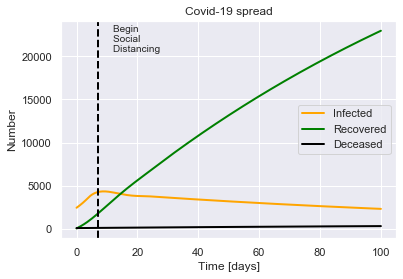

In [28]:
SIRDQ(R0=2.4, M=0.01, P=14, Q0=0.62, tQ=7).solve(uk_initial_conditions, tf=100).plot(susceptible=False)

This suggests that with advanced methods for contact tracing and isolation, it is possible to prevent the epidemic growing further, which would save thousands of lives.

However, the measures would likely still have to be in place for several months in order to reduce the number of cases.

At this point, more advanced models of virus propagation are really required.

## Summary

We have seen that:

- Very simple and intuitive mathematical models can reproduce the same overall trends as more complex epidemiological models.
- If unchecked, the virus will spread exponentially through a large fraction of the population.
- In the worst-case scenario, the total death toll in the UK alone could be in the hundreds of thousands.
- The peak load on the healthcare system might not be reached for 2-3 months.
- Widespread social distancing can help reduce the number of cases, and limit the burden on the healthcare system.
- The earlier social distancing begins the lower the number of cases will be.
- However, slacking off on the social distancing could lead to a re-emergence of the virus.
- Specifically isolating the most vulnerable segments of the population can significantly reduce the overall mortality rate.

All of these conclusions agree with detailed [published studies](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf?fbclid=IwAR1j0zcv_htn0A6OHNGhDkV5Facsz_jLVJxYtel7MEl1b7VvBsPgnkcXMAM).